In [1]:
#PARAMS
OUTPUT_SEQUENCE_LENGTH = 50
EMBEDDING_DIMENSION = 50
ALPHA = 0
BATCH_SIZE = 512

#Installing Libraries

In [ ]:
!pip install transformers
!pip install spacy
!pip install tensorflow

!pip install datasets

!spacy download en_core_web_sm

#Importing libraries and mounting google drive

In [3]:
import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import Sequence

from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from datasets import load_from_disk, Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading dataset

In [7]:
rte = load_from_disk("/content/drive/MyDrive/CS685/project/datasets/RTE")

In [9]:
rte

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence1', 'sentence2', 'label', 'logits', 'combined_logits'],
        num_rows: 21147
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

#Creating embeddings and padded sequences

In [8]:
sentences = rte['train']['sentence1']+rte['train']['sentence2']
combined_logits = rte['train']['combined_logits']
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=OUTPUT_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(sentences).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

import os
path_to_glove_file = "/content/drive/MyDrive/CS685/project/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15007 words (1574 misses)


#Embedding Layer

In [6]:
import torch
cur_batch_size = 128
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
)

In [10]:
cur_batch_size = BATCH_SIZE

# Define a function to preprocess a single batch of data
def preprocess_batch(batch_data):
  sentences1, sentences2, combined_logits = batch_data['sentence1'], batch_data['sentence2'], batch_data['combined_logits']
  
  sentences1_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences1)).numpy())
  sentences2_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences2)).numpy())

  padded_sequences = tf.concat((sentences1_data, sentences2_data, sentences1_data*sentences2_data, tf.math.abs(sentences1_data - sentences2_data)), axis=1)
  combined_logits = np.array(combined_logits)
  return padded_sequences, combined_logits

padded_sequences, labels = preprocess_batch(rte['train'])

In [11]:
from tqdm.notebook import tqdm

#Custom loss and Custom Accuracy metric Iterating on alpha to find the best alpha

In [13]:
# alpha = ALPHA
class TotalLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    # print(y_true)
    true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
    # print(teacher_logits.shape, teacher_logits.shape)
    teacher_logits = teacher_logits[:, 0]
    # print(teacher_logits.shape, teacher_logits.shape)
    loss_wrt_teacher = tf.math.reduce_mean(tf.square(teacher_logits - y_pred))
    loss_wrt_true = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, logits=y_pred))
    # print("loss_wrt_teacher", loss_wrt_teacher,"loss_wrt_true", loss_wrt_true)
    return alpha*loss_wrt_true+(1-alpha)*loss_wrt_teacher

class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
      true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
      y_pred = tf.argmax(y_pred, axis=-1)
      y_true = tf.argmax(true_labels, axis=-1)
      y_true = tf.squeeze(y_true)
      cur_correct = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
      cur_smaples = tf.cast(tf.size(y_pred), tf.float32)
      # print("cur_correct", cur_correct, "cur_smaples", cur_smaples)
      
      self.total_correct.assign_add(cur_correct)
      self.total_samples.assign_add(cur_smaples)
    
    def result(self):
        return self.total_correct / self.total_samples
    
    def reset_state(self):
        self.total_correct.assign(0.0)
        self.total_samples.assign(0.0)

for alpha in tqdm([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):

  try:
    del model
  except Exception as e:
    print('No Model')

  model = Sequential()
  model.add(Bidirectional(LSTM(300, return_sequences=False), input_shape=(4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION)))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
  model.add(Dropout(0.2)) # Avoid Overfitting
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2)) #OutputClasses
  optimizer = Adam(learning_rate=0.0001)
  # optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)
  model.compile(
      loss=TotalLoss(), 
      optimizer=optimizer, 
      metrics=[CustomAccuracy()],
      run_eagerly = True
  )
  model.build(input_shape=(cur_batch_size, 4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION))
  model.summary()


  history = model.fit(
      padded_sequences,
      labels,
      epochs=5,
      verbose=1,
      batch_size=cur_batch_size,
      validation_split=0.1
  )

  print('alpha', alpha)
  print(history.history['val_accuracy'])
  print(history.history['accuracy'])

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 600)              842400    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 600)               0         
                                                                 
 dense_12 (Dense)            (None, 400)               240400    
                                                                 
 dropout_13 (Dropout)        (None, 400)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 802       
                                                                 
Total params: 1,083,602
Trainable params: 1,083,602
Non-trainable params: 0
____________________________________________

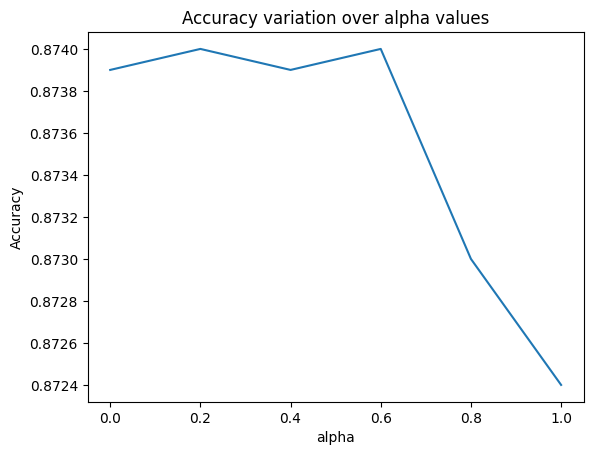

In [15]:
import matplotlib.pyplot as plt
x = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
y = [0.8739, 0.8740, 0.8739, 0.8740, 0.8730, 0.8724]
fig = plt.plot(x, y)
title = plt.title("Accuracy variation over alpha values")
xlabel = plt.xlabel("alpha")
ylabel = plt.ylabel("Accuracy")

#Training the model with best alpha found

In [16]:
alpha = 0.0 # Best Value

try:
    del model
except Exception as e:
  print('No Model')

model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=False), input_shape=(4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION)))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
model.add(Dropout(0.2)) # Avoid Overfitting
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2)) #OutputClasses
# optimizer = Adam(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)
model.compile(
    loss=TotalLoss(), 
    optimizer=optimizer, 
    metrics=[CustomAccuracy()],
    run_eagerly = True
)
model.build(input_shape=(cur_batch_size, 4*OUTPUT_SEQUENCE_LENGTH, EMBEDDING_DIMENSION))
model.summary()


history = model.fit(
    padded_sequences,
    labels,
    epochs=15,
    verbose=1,
    batch_size=cur_batch_size,
    validation_split=0.1
)

print(history.history['val_accuracy'])
print(history.history['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 600)              842400    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 600)               0         
                                                                 
 dense_24 (Dense)            (None, 400)               240400    
                                                                 
 dropout_25 (Dropout)        (None, 400)               0         
                                                                 
 dense_25 (Dense)            (None, 2)                 802       
                                                                 
Total params: 1,083,602
Trainable params: 1,083,602
Non-trainable params: 0
___________________________________________

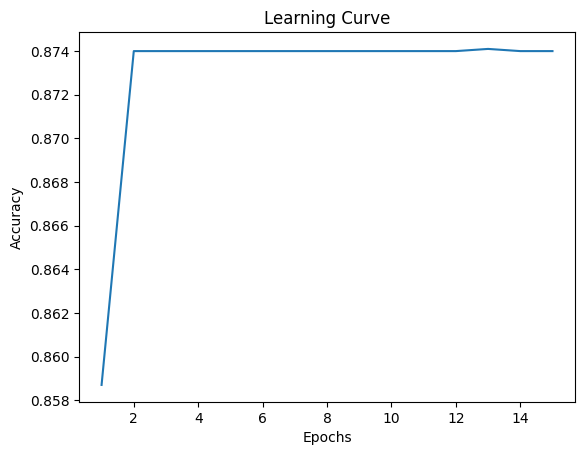

In [17]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 16, 1)]
y = [0.8587, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8740, 0.8741, 0.8740, 0.8740]

fig = plt.plot(x, y)
title = plt.title("Learning Curve")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

#Computig the metrics

In [18]:
def get_test_data(data):
  sentences1, sentences2, labels = data['sentence1'], data['sentence2'], data['label']
  
  sentences1_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences1)).numpy())
  sentences2_data = tf.convert_to_tensor(embedding_layer(vectorizer(sentences2)).numpy())

  padded_sequences = tf.concat((sentences1_data, sentences2_data, sentences1_data*sentences2_data, tf.math.abs(sentences1_data - sentences2_data)), axis=1)
  labels = np.array(labels)
  return padded_sequences, labels
#Code for f1 score, accuracy and confusion matrix

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

test_padded_sequences, true_lables = get_test_data(rte['validation'])

predictions = model.predict(test_padded_sequences)
class_labels = np.argmax(predictions, axis=-1)

cm = confusion_matrix(true_lables, class_labels)
f1 = f1_score(true_lables, class_labels)
accuracy = accuracy_score(true_lables, class_labels)

print("Confusion Matrix: \n", cm)
print("F1 Score:", f1)
print('Accuracy:', accuracy)

9/9 [==============================] - 0s 31ms/step
Confusion Matrix: 
 [[  0 146]
 [  0 131]]
F1 Score: 0.642156862745098
Accuracy: 0.4729241877256318


In [20]:
flag = np.array(class_labels == true_lables)
missed_values = []
identified_values = []
for i, f in enumerate(flag):
  if f:
    identified_values.append((rte['validation'][i]['sentence1'], rte['validation'][i]['sentence2'], rte['validation'][i]['label']))

for i, f in enumerate(flag):
  if not f:
    missed_values.append((rte['validation'][i]['sentence1'], rte['validation'][i]['sentence2'], rte['validation'][i]['label']))

In [22]:
len(missed_values)

146

#Failed Cases

In [21]:
missed_values
# s1 -> premise
# s2 -> hypothesis
#1 - can infer, 0 - can't infer

[('Yet, we now are discovering that antibiotics are losing their effectiveness against illness. Disease-causing bacteria are mutating faster than we can come up with new antibiotics to fight the new variations.',
  'Bacteria is winning the war against antibiotics.',
  0),
 ('Security forces were on high alert after an election campaign in which more than 1,000 people, including seven election candidates, have been killed.',
  'Security forces were on high alert after a campaign marred by violence.',
  0),
 ('In 1979, the leaders signed the Egypt-Israel peace treaty on the White House lawn. Both President Begin and Sadat received the Nobel Peace Prize for their work. The two nations have enjoyed peaceful relations to this day.',
  'The Israel-Egypt Peace Agreement was signed in 1979.',
  0),
 ('singer and actress Britney Spears, 24, has filled papers in Los Angeles County Superior Court to divorce her husband Kevin Federline, 28. A spokeswoman for the court, Kathy Roberts stated that th